In [51]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch import nn

import nibabel as nib
from nilearn import maskers
from nilearn.plotting import plot_stat_map
from neurovlm.data import fetch_data

from neurovlm.data import fetch_data
from neurovlm.models import NeuroAutoEncoder
from neurovlm.train import Trainer, which_device
device = which_device()

# Autoencoder

The first step is to reduce the dimensionality of the 28k MNI space neuro vector. Several work uses difumo. Instead, we use an autoencoder to map from $d=28,000$ to a $k=384$ latent space. 

## Load Neurovectors

Results from the coordinate smoothing notebook.

In [52]:
data_dir = fetch_data()

neuro_vectors, pmids = torch.load(
    data_dir / "neuro_vectors.pt", weights_only=False
).values()

In [53]:
df_pubs = pd.read_parquet(data_dir / "publications_more.parquet")
df_coords = pd.read_parquet(data_dir / "coordinates_more.parquet")

In [54]:
coord_counts = df_coords.groupby("pmid")["doi"].count()
pmids_less = coord_counts[coord_counts <= 100].index
mask = pd.Series(pmids).isin(pmids_less).values
neuro_vectors = neuro_vectors[mask]

## Training

Train an autoencoder on the neuro-vectors.

1. Encoder: Neuro-vector to low-dimensional (384) latent vector / embedding space
2. Decoder: Latent vector to produces MNI space predictions.

Training is complete in two stages:

1. Initial training anywhere neurovectors > 0
2. Additional training to shrink the size of activations closer to targets

In [55]:
# Train/test/validation split
inds = torch.arange(len(neuro_vectors))
train_inds, test_inds = train_test_split(
    inds, train_size=0.8, random_state=0
)
test_inds, val_inds = train_test_split(
    test_inds, train_size=0.5, random_state=1
)

In [56]:
# Initial training on hard threshold targets
neuro_vectors_bin = neuro_vectors.clone()
neuro_vectors_bin[neuro_vectors_bin > 0.0] = 1.0

trainer = Trainer(
    NeuroAutoEncoder(seed=0, out="logit"),
    n_epochs=10,
    batch_size=256,
    lr=1e-3,
    loss_fn=nn.BCEWithLogitsLoss(),
    optimizer=torch.optim.AdamW,
    X_val=neuro_vectors_bin[val_inds],
    device="auto"
)

# Fit
trainer.fit(neuro_vectors_bin[train_inds])

# Save
trainer.save(data_dir / "autoencoder_init.pt")

# Unpack
autoencoder_init = trainer.model
# Epoch: 9,  val loss:  0.69321 (initial) -> 0.22368 (current)

Epoch: -1, val loss: 0.69321
Epoch: 0, val loss: 0.32754
Epoch: 1, val loss: 0.29923
Epoch: 2, val loss: 0.27754
Epoch: 3, val loss: 0.26455
Epoch: 4, val loss: 0.25265
Epoch: 5, val loss: 0.24298
Epoch: 6, val loss: 0.23511
Epoch: 7, val loss: 0.22585
Epoch: 8, val loss: 0.21995
Epoch: 9, val loss: 0.21323


In [ ]:
# autoencoder_init = torch.load(data_dir / "autoencoder_init.pt", weights_only=False)

In [57]:
# Additional training on tighter thresholded targets
neuro_vectors_bin = neuro_vectors.clone()
neuro_vectors_bin[neuro_vectors_bin > 0.001] = 1.0

trainer = Trainer(
    autoencoder_init,
    n_epochs=20,
    batch_size=256,
    lr=1e-4,
    loss_fn=nn.BCEWithLogitsLoss(),
    optimizer=torch.optim.AdamW,
    X_val=neuro_vectors_bin[val_inds],
    device="auto"
)

# Fit
trainer.fit(neuro_vectors_bin[train_inds])

# Save
trainer.save(data_dir / "autoencoder_sparse.pt")

# Unpack
autoencoder_soft = trainer.model
# Epoch: 19,  val loss:  0.13086 (initial) -> 0.11747 (current)

Epoch: -1, val loss: 0.12954
Epoch: 0, val loss: 0.12045
Epoch: 1, val loss: 0.11911
Epoch: 2, val loss: 0.11828
Epoch: 3, val loss: 0.11758
Epoch: 4, val loss: 0.11705
Epoch: 5, val loss: 0.11663
Epoch: 6, val loss: 0.11623
Epoch: 7, val loss: 0.11583
Epoch: 8, val loss: 0.11565
Epoch: 9, val loss: 0.11533
Epoch: 10, val loss: 0.11507
Epoch: 11, val loss: 0.11491
Epoch: 12, val loss: 0.11471
Epoch: 13, val loss: 0.11457
Epoch: 14, val loss: 0.11444
Epoch: 15, val loss: 0.11435
Epoch: 16, val loss: 0.11422
Epoch: 17, val loss: 0.11417
Epoch: 18, val loss: 0.11411
Epoch: 19, val loss: 0.11389


In [58]:
# Skip above if previously trained
autoencoder = torch.load(
   data_dir / "autoencoder_sparse.pt", weights_only=False
).to(device)

## Save Latent Vectors

In [59]:
# Encode neuro vectors
with torch.no_grad():
    latent_neuro = autoencoder.encoder(neuro_vectors_bin.to("mps")).detach()

In [60]:
torch.save(dict(latent=latent_neuro, pmid=pmids_less), data_dir / "latent_neuro_sparse.pt")

## Results

Plot an example.

In [61]:
import matplotlib.pyplot as plt

data_dir = fetch_data()
mask_arrays = np.load(f"{data_dir}/mask.npz", allow_pickle=True)
mask_img = nib.Nifti1Image(mask_arrays["mask"].astype(float),  mask_arrays["affine"])
masker = maskers.NiftiMasker(mask_img=mask_img, dtype=np.float32).fit()

neuro_vectors_bin = neuro_vectors.clone()
neuro_vectors_bin[neuro_vectors_bin > 0.001] = 1.0

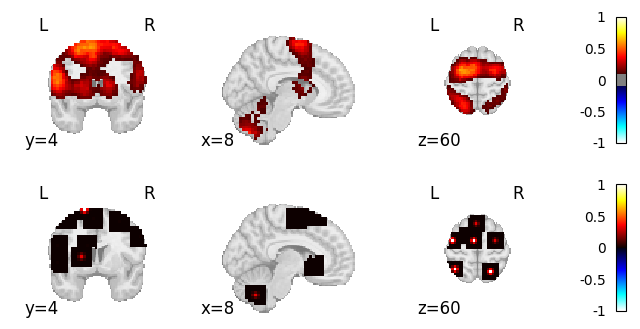

In [62]:
# Prediction
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 4))
idx = 3
out = torch.sigmoid(autoencoder.cpu()(neuro_vectors_bin[val_inds][idx]))
plot_stat_map(masker.inverse_transform(out.cpu().detach()), cut_coords=np.array([8, 4, 60]),
              cmap="cold_hot", vmin=-1, vmax=1, threshold=0.1, draw_cross=False, axes=axes[0]);

# ALEKernel target
plot_stat_map(masker.inverse_transform(neuro_vectors[val_inds][idx]), cut_coords=np.array([8, 4, 60]),
              cmap="cold_hot", vmin=-1, vmax=1, threshold=0., draw_cross=False, axes=axes[1]);